In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from pandas import DataFrame

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

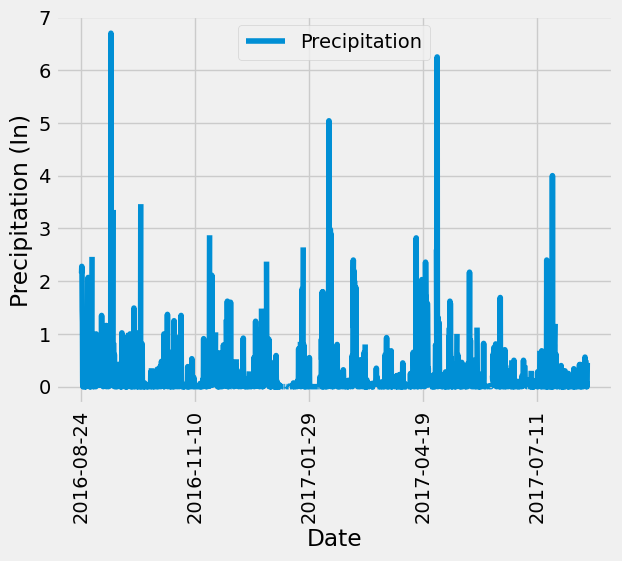

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# ChatGPT
start_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

start_object = dt.datetime.strptime(start_date.date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
end_object = start_object - dt.timedelta(days=365)

# # Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > end_object)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation)
# new_df = df.groupby('date').sum()

# Sort the dataframe by date
new_df = df.sort_values('date')

# # Use Pandas Plotting with Matplotlib to plot the data
new_df.plot('date', 'prcp', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (In)')
plt.legend(['Precipitation'])
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
new_df = df.groupby('date').sum()
# mean = new_df.mean()
# median = new_df.median()
# mode = new_df.mode()

new_df.describe()

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
count = session.query(station).count()
count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# ChatGPT
station_instance = session.query(measurement.station, func.count().label('station_count')).group_by(measurement.station).order_by(func.count().desc()).all()
station_df = pd.DataFrame(station_instance, columns=['station', 'station_count'])
station_df


,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# ChatGPT
station = station_df['station'][0]

filtered_station = session.query(measurement).filter(measurement.station == station).all()
data = [{"date": row.date, "tobs": row.tobs} for row in filtered_station]
filtered_station_df = pd.DataFrame(data)

min_temp = filtered_station_df['tobs'].min()
max_temp = filtered_station_df['tobs'].max()
avg_temp = filtered_station_df['tobs'].mean()

print(f'Min temp is {min_temp}')
print(f'Max temp is {max_temp}')
print(f'Mean temp is {round(avg_temp,1)}')


Min temp is 54.0
Max temp is 85.0
Mean temp is 71.7


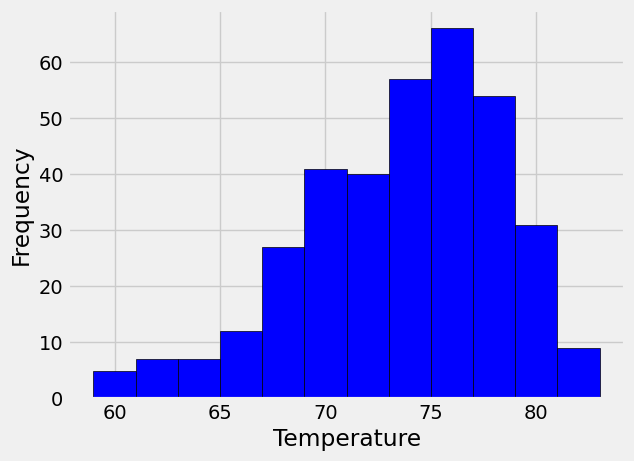

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
start_temp = filtered_station_df['date'].iloc[-1]
start_temp_dt = pd.to_datetime(start_temp)

end_temp_dt = start_temp_dt - dt.timedelta(days=365)

filtered_station_df['date'] = pd.to_datetime(filtered_station_df['date'])
filtered_station_year_df = filtered_station_df[filtered_station_df['date'] > end_temp_dt]

filtered_station_year_df['tobs'].hist(bins=12, color='blue', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()



# Close Session

In [16]:
# Close Session
session.close()